In [1]:
# Goal: re-write FOCuS algorithm that works for both mu>0 and mu<0, where the sign isn't known
# Experiment with changepoint estimate location over time and see if it's deviation is bounded
# Compare statistic with naively computed GLR in both mu>0 and mu<0

In [21]:
import numpy as np
from scipy.stats import norm

nu = int(1e3)
T = int(1e6)
data = np.zeros(T)
mu0 = 0
var = 1
mu1 = 1
data[:nu] = norm.rvs(size=nu)
data[nu:] = norm.rvs(loc=mu1,size=T-nu)
threshold = 10

In [22]:
import sys

# Implementation of FOCuS for mu>0
quadratics = [(0,0,0)]
# tau, s, l
S = 0

for t in range(T):
    S = S + data[t]
    # Recall time step are different from index in array
    # Time steps are 1-indexed so adding t+1
    k = len(quadratics)
    quadratic_add = [t+1,S,np.inf]
    i = k
    while (2*(quadratic_add[1]-quadratics[i-1][1])-(quadratic_add[0]-quadratics[i-1][0])*quadratics[i-1][2])<=0 and i>=1:
        i = i-1
        # I might change this to i>=2 because I'm not sure how it handles it when i=0
        # Although this would be saying the zero line is more optimal than any quadratic so I'm pretty sure this is impossible
    quadratic_add[2] = max(0,2*(quadratic_add[0]-quadratics[i-1][0])/(quadratic_add[2]-quadratics[i-1][2]))
    quadratics = quadratics[:i].copy()
    quadratics.append(tuple(quadratic_add))

    glr = max([(S-quadratic[1])**2/(2*(t+1-quadratic[0])) for quadratic in quadratics[:-1]]+[0])
    # Here 0 corresponds to the last quadratic 
    if glr>=threshold:
        print(f'stopping time: {t+1}')
        print(glr)
        break

stopping time: 1010
11.397850662922883


In [24]:
# All of the above code works for positive mean change but not for negative for some reason
# Romano says the algorithm has to updated separately for both mu>0 and mu<0 so we'll work next on doing it for mu<0

In [29]:
import sys

# Implementation of FOCuS for mu>0
quadratics = [(0,0,0)]
# tau, s, l
S = 0

for t in range(T):
    S = S + data[t]
    # Recall time step are different from index in array
    # Time steps are 1-indexed so adding t+1
    k = len(quadratics)
    quadratic_add = [t+1,S,-np.inf]
    i = k
    while (2*(quadratic_add[1]-quadratics[i-1][1])-(quadratic_add[0]-quadratics[i-1][0])*quadratics[i-1][2])>=0 and i>=1:
        i = i-1
        # I might change this to i>=2 because I'm not sure how it handles it when i=0
        # Although this would be saying the zero line is more optimal than any quadratic so I'm pretty sure this is impossible
    quadratic_add[2] = min(0,2*(quadratic_add[0]-quadratics[i-1][0])/(quadratic_add[2]-quadratics[i-1][2]))
    quadratics = quadratics[:i].copy()
    quadratics.append(tuple(quadratic_add))

    glr = max([(S-quadratic[1])**2/(2*(t+1-quadratic[0])) for quadratic in quadratics[:-1]]+[0])
    # Here 0 corresponds to the last quadratic 
    if glr>=threshold:
        print(f'stopping time: {t+1}')
        print(glr)
        break

stopping time: 1013
10.022603359397088


In [31]:
# Ok the above works for mu<0 detection
# Next step is to combine the two

In [1]:
import numpy as np
from scipy.stats import norm

nu = int(1e3)
T = int(1e7)
data = np.zeros(T)
mu0 = 0
var = 1
mu1 = 1
data[:nu] = norm.rvs(size=nu)
data[nu:] = norm.rvs(loc=mu1,size=T-nu)
threshold = 10

In [2]:
import sys

# Implementation of FOCuS for any mu
quadratics_positive = [(0,0,0)]
quadratics_negative = [(0,0,0)]
# tau, s, l
S = 0
changepoint_history = []
glr_history = []

for t in range(T):
    S = S + data[t]
    # Recall time step are different from index in array
    # Time steps are 1-indexed so adding t+1
    #Positive update first
    k = len(quadratics_positive)
    quadratic_add = [t+1,S,np.inf]
    i = k
    while (2*(quadratic_add[1]-quadratics_positive[i-1][1])-(quadratic_add[0]-quadratics_positive[i-1][0])*quadratics_positive[i-1][2])<=0 and i>=1:
        i = i-1
    quadratic_add[2] = max(0,2*(quadratic_add[0]-quadratics_positive[i-1][0])/(quadratic_add[2]-quadratics_positive[i-1][2]))
    quadratics_positive = quadratics_positive[:i].copy()
    quadratics_positive.append(tuple(quadratic_add))

    # Now negative update
    k = len(quadratics_negative)
    quadratic_add = [t+1,S,-np.inf]
    i = k
    while (2*(quadratic_add[1]-quadratics_negative[i-1][1])-(quadratic_add[0]-quadratics_negative[i-1][0])*quadratics_negative[i-1][2])>=0 and i>=1:
        i = i-1
    quadratic_add[2] = min(0,2*(quadratic_add[0]-quadratics_negative[i-1][0])/(quadratic_add[2]-quadratics_negative[i-1][2]))
    quadratics_negative = quadratics_negative[:i].copy()
    quadratics_negative.append(tuple(quadratic_add))
    # Combine two and check
    # glr = max([(S-quadratic[1])**2/(2*(t+1-quadratic[0])) for quadratic in quadratics_positive[:-1]]+[(S-quadratic[1])**2/(2*(t+1-quadratic[0])) for quadratic in quadratics_negative[:-1]]+[0])
    # Here 0 corresponds to the last quadratic 
    best_changepoint = 0
    best_glr = 0
    for quadratic in quadratics_positive + quadratics_negative:
        if t+1-quadratic[0]==0: 
            continue
        elif (S-quadratic[1])**2/(2*(t+1-quadratic[0]))>best_glr:
            best_glr = (S-quadratic[1])**2/(2*(t+1-quadratic[0]))
            best_changepoint = quadratic[0]
    changepoint_history.append(best_changepoint)   
    glr_history.append(best_glr)
    if best_glr>=threshold:
        print(f'stopping time: {t+1}')
        print(best_glr)
        break

stopping time: 1022
10.548252210913546


In [3]:
# Naive O(n^2) implementation of GLR 
changepoint_history_naive = []
glr_history_naive = []
for t in range(T):
    n = t+1
    glr_values = []
    for s in range(n):
        glr_s = 0.5*np.sum(data[s:n])**2/(n-s)
        glr_values.append(glr_s)
    glr = max(glr_values)
    glr_history_naive.append(glr)
    changepoint_history_naive.append(int(np.argmax(glr_values)))
    if glr>=threshold:
        print(f'stopping time: {t+1}')
        print(glr)
        break

stopping time: 1022
10.548252210913539


In [4]:
all(list(np.array(changepoint_history_naive) == np.array(changepoint_history)))

True

In [10]:
glr_history[28]

np.float64(0.6429537193047168)

In [11]:
glr_history_naive[28]

np.float64(0.6429537193047165)

In [9]:
np.where(np.array(glr_history)==np.array(glr_history_naive))

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   13,   16,   18,   19,   20,   21,   22,   23,   24,   25,
          32,   34,   35,   36,   42,   44,   51,   54,   55,   56,   57,
          59,   60,   61,   62,   66,   67,   79,   91,   92,   98,   99,
         100,  101,  102,  103,  104,  105,  106,  107,  109,  112,  115,
         118,  122,  126,  128,  129,  130,  131,  132,  133,  136,  137,
         138,  140,  146,  147,  148,  151,  155,  156,  158,  159,  161,
         162,  163,  164,  167,  172,  173,  176,  177,  178,  179,  180,
         181,  185,  187,  188,  189,  190,  191,  192,  193,  194,  196,
         198,  199,  200,  201,  203,  205,  208,  210,  211,  212,  222,
         225,  228,  230,  231,  233,  237,  238,  239,  240,  242,  243,
         244,  245,  246,  247,  248,  249,  250,  251,  252,  255,  256,
         257,  258,  259,  260,  262,  269,  280,  281,  282,  286,  295,
         301,  305,  310,  312,  320, 

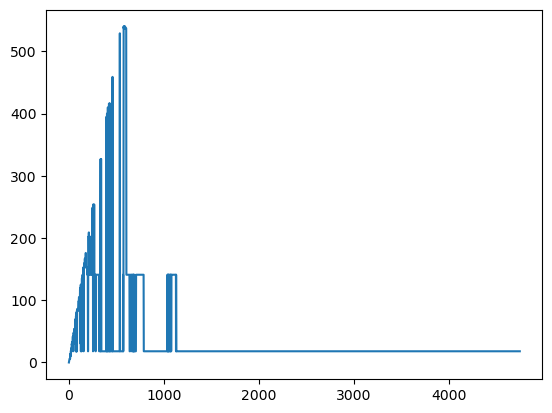

In [16]:
import matplotlib.pyplot as plt

plt.plot(changepoint_history_naive)

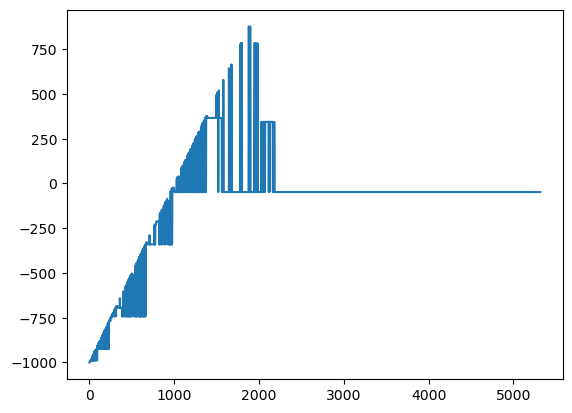

In [31]:
import matplotlib.pyplot as plt

plt.plot(np.array(changepoint_history)-1000)

In [ ]:
# All of the above seems to confirm my analysis is correct
# One thing I want to do when I can let this run for an hour without checking is trying the following paramemters:
# nu=0, mu=-0.001, threshold=200, T=1e7